In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
%matplotlib inline

In [64]:
df = pd.read_csv('josh_final_dataset_7.12.csv')

In [65]:
del df['Unnamed: 0']

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45411 entries, 0 to 45410
Data columns (total 27 columns):
Assets                                                                                                         39525 non-null float64
adsh                                                                                                           39525 non-null object
cik                                                                                                            45411 non-null int64
coreg                                                                                                          54 non-null object
ddate                                                                                                          39525 non-null float64
ein                                                                                                            37612 non-null float64
fy                                                                                            

## Dividing (Identifying) which companies are foreign and domestic

In [67]:
df['check1']=np.where(df.IncomeLossFromContinuingOperationsBeforeIncomeTaxesForeign.isnull(),0,1)
df['check2']=np.where(df.UndistributedEarningsOfForeignSubsidiaries.isnull(),0,1)
df['check3']=np.where(df.ForeignEarningsRepatriated.isnull(),0,1)

df['check']=df['check1']+df['check2']+df['check3']

In [68]:
del df['check1']
del df['check2']
del df['check3']

In [69]:
# Giving identifiers to companies as to whether each of them has foreign subsidiary(foreign operation) or not
df['Type of Firm'] = np.where(df.check==0,'Domestic','Foreign')

In [70]:
del df['check']

## Giving each company industry classification & Creating [Liabilities/Assets]

In [71]:
industry_count =\
pd.DataFrame([{'Mining and Construction':3551, 'Manufacturing':13162, 'Transportation, Communication, Electric, Gas':2889,
 'Wholesale, Retail':3116,'Financial, Insurance, Real Estate':9625, 'Services':6725,'Public Administration':103}],index=['count'])

# industry_count.to_csv('industry_count_breakdown.csv')

In [72]:
industry_count

,"Financial, Insurance, Real Estate",Manufacturing,Mining and Construction,Public Administration,Services,"Transportation, Communication, Electric, Gas","Wholesale, Retail"
count,9625,13162,3551,103,6725,2889,3116


In [73]:
# bins = pd.IntervalIndex.from_tuples([(1000, 1999), (2000, 3999),(4000,4999),(5000,5999),
#                                     (6000,6999),(7000,8999),(9000,9999)],closed='both')

df['industry']=\
pd.cut(df.sic.tolist(),[1000,1999,3999,4999,5999,6999,8999,9999],include_lowest=True,
             labels=['Mining and Construction','Manufacturing','Transportation, Communication, Electric, Gas',
               'Wholesale, Retail','Financial, Insurance, Real Estate','Services','Public Administration'])

In [74]:
# Creating new variable (R&D / Assets)
df['Liabilities_scaled']=\
df['Liabilities']/df['Assets']

## Research and Development Expenses - Simple Comparison

In [75]:
# Sum of domestic income per year by type
liabilities_sum =\
pd.DataFrame(df[df['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].sum()).reset_index()

In [76]:
# Number of firms per year by type
liabilities_count =\
pd.DataFrame(df[df['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

Text(0.5,1,'Total Liabilities of Domestic Firms and MNCs')

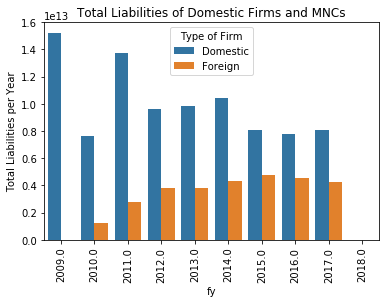

In [77]:
# plt.figure().add_subplot(111).set_yticklabels([0,25,50,75,100,125,150,175,200])
sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_sum)
plt.xticks(rotation='vertical')
plt.ylabel('Total Liabilities per Year')
plt.title('Total Liabilities of Domestic Firms and MNCs')

Text(0.5,1,'Number of Firms by Type')

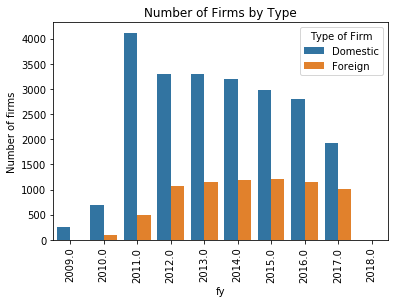

In [78]:
sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_count)
plt.xticks(rotation='vertical')
plt.ylabel('Number of firms')
plt.title('Number of Firms by Type')

## Limiting data to fixed fy years for accurate analysis

In [79]:
# Data only from fy 2013 to fy 2016
df_13_16 = df[(df.fy>=2013) & (df.fy<=2016)]

# Drop firms that have at least one missing Asset values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Assets'])))

# Drop firms that have Asset value of 0
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(x['Assets']!=0.0))

# Drop firms that have at least one missing R&D values from fy 2013-2016
df_13_16 = df_13_16.groupby('cik').filter(lambda x: all(pd.notnull(x['Liabilities'])))

# Filter only the companies that have data for all fy years 2013 - 2016 (4 assets values per cik group)
df_13_16 = df_13_16.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

df_13_16_foreign = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Foreign']
df_13_16_domestic = df_13_16.copy()[df_13_16.copy()['Type of Firm']=='Domestic']

As we can see below, the problem is there are some firms that was domestic one year and was multinational for another year (inconsistent). We are going to drop those companies and exclude them from the analysis

In [80]:
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    613
2014.0    643
2015.0    673
2016.0    685
dtype: int64 

 Domestic: fy
2013.0    1445
2014.0    1415
2015.0    1385
2016.0    1373
dtype: int64


In [81]:
# Dropping MNCs that have missing UFEs for all years
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: all(pd.notnull(x['UndistributedEarningsOfForeignSubsidiaries'])))

In [82]:
df_13_16_foreign = df_13_16_foreign.groupby('cik').filter(lambda x: x['fy'].nunique()==4)
df_13_16_domestic = df_13_16_domestic.groupby('cik').filter(lambda x: x['fy'].nunique()==4)

# Now we have the same number of multinational firms and domestic firms throughout all years
print("Foreign:",df_13_16_foreign.groupby('fy').size(),"\n\n","Domestic:", df_13_16_domestic.groupby('fy').size())

Foreign: fy
2013.0    263
2014.0    263
2015.0    263
2016.0    263
dtype: int64 

 Domestic: fy
2013.0    1344
2014.0    1344
2015.0    1344
2016.0    1344
dtype: int64


In [83]:
# Make a new dataframe df_13_16 with the modified foreign and domestic firms data
df_13_16= df_13_16_foreign.append(df_13_16_domestic)

## Comparison by Industry

- Industry1: 'Mining and Construction'
- Industry2: 'Manufacturing'
- Industry3: 'Transportation, Communication, Electric, Gas'
- Industry4: 'Wholesale, Retail'
- Industry5: 'Financial, Insurance, Real Estate'
- Industry6: 'Services'
- Industry7: 'Public Administration'

In [84]:
# Dividing data into 7 different industries

liabilities_industry1 = df_13_16.copy()[df_13_16.copy().industry=='Mining and Construction']
liabilities_industry2 = df_13_16.copy()[df_13_16.copy().industry=='Manufacturing']
liabilities_industry3 = df_13_16.copy()[df_13_16.copy().industry=='Transportation, Communication, Electric, Gas']
liabilities_industry4 = df_13_16.copy()[df_13_16.copy().industry=='Wholesale, Retail']
liabilities_industry5 = df_13_16.copy()[df_13_16.copy().industry=='Financial, Insurance, Real Estate']
liabilities_industry6 = df_13_16.copy()[df_13_16.copy().industry=='Services']
liabilities_industry7 = df_13_16.copy()[df_13_16.copy().industry=='Public Administration']

### Industry 1: Mining and Construction

In [85]:
# Count of firms in Mining and Construction
liabilities_industry1_count =\
pd.DataFrame(liabilities_industry1[liabilities_industry1['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [86]:
# Mean of (Liabilities / Assets) of firms in Mining and Construction per year
liabilities_industry1_mean_scaled =\
pd.DataFrame(liabilities_industry1[liabilities_industry1['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [87]:
# Difference of scaled mean between domestic firms and MNCs (Mining and Construction)
liabilities_industry1_mean_diff = \
liabilities_industry1_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[0] - x.iloc[1])

liabilities_industry1_mean_diff = pd.DataFrame(liabilities_industry1_mean_diff).reset_index()

### Industry 2: Manufacturing

In [88]:
# Count of firms in Manufacturing
liabilities_industry2_count =\
pd.DataFrame(liabilities_industry2[liabilities_industry2['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [89]:
# Mean of (Liabilities/ Assets) of firms in Manufacturing per year
liabilities_industry2_mean_scaled =\
pd.DataFrame(liabilities_industry2[liabilities_industry2['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [90]:
# Difference of scaled mean between domestic firms and MNCs (Manufacturing)
liabilities_industry2_mean_diff = \
liabilities_industry2_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[1] - x.iloc[0])

liabilities_industry2_mean_diff = pd.DataFrame(liabilities_industry2_mean_diff).reset_index()

### Industry 3: Transportation, Communication, Electric, Gas

In [91]:
# Count of firms in Transportation, Communication, Electric, Gas
liabilities_industry3_count =\
pd.DataFrame(liabilities_industry3[liabilities_industry3['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [92]:
# Mean of (Liabilities / Assets) of firms in Transportation, Communication, Electric, Gas
liabilities_industry3_mean_scaled =\
pd.DataFrame(liabilities_industry3[liabilities_industry3['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [93]:
# Difference of scaled mean between domestic firms and MNCs (Transportation, Communication, Electric, Gas)
liabilities_industry3_mean_diff = \
liabilities_industry3_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[0] - x.iloc[1])

liabilities_industry3_mean_diff = pd.DataFrame(liabilities_industry3_mean_diff).reset_index()

### Industry 4: Wholesale, Retail

In [94]:
# Count of firms in Wholesale, Retail
liabilities_industry4_count =\
pd.DataFrame(liabilities_industry4[liabilities_industry4['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [95]:
# Mean of (Liabilities / Assets) of firms in Wholesale, Retail
liabilities_industry4_mean_scaled =\
pd.DataFrame(liabilities_industry4[liabilities_industry4['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [96]:
# Difference of scaled mean between domestic firms and MNCs (Wholesale, Retail)
liabilities_industry4_mean_diff = \
liabilities_industry4_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[0] - x.iloc[1])

liabilities_industry4_mean_diff = pd.DataFrame(liabilities_industry4_mean_diff).reset_index()

### Industry 5: Financial, Insurance, Real Estate

In [97]:
# Count of firms in Financial, Insurance, Real Estate
liabilities_industry5_count =\
pd.DataFrame(liabilities_industry5[liabilities_industry5['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [98]:
# Mean of (Liabilities / Assets) of firms in Financial, Insurance, Real Estate
liabilities_industry5_mean_scaled =\
pd.DataFrame(liabilities_industry5[liabilities_industry5['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [99]:
# Difference of scaled mean between domestic firms and MNCs (Financial, Insurance, Real Estate)
liabilities_industry5_mean_diff = \
liabilities_industry5_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[0] - x.iloc[1])

liabilities_industry5_mean_diff = pd.DataFrame(liabilities_industry5_mean_diff).reset_index()

### Industry 6: Services

In [100]:
# Count of firms in Services
liabilities_industry6_count =\
pd.DataFrame(liabilities_industry6[liabilities_industry6['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [101]:
# Mean of (Liabilities / Assets) of firms in Services
liabilities_industry6_mean_scaled =\
pd.DataFrame(liabilities_industry6[liabilities_industry6['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [102]:
# Difference of scaled mean between domestic firms and MNCs (Services)
liabilities_industry6_mean_diff = \
liabilities_industry6_mean_scaled.groupby('fy')['Liabilities_scaled'].\
apply(lambda x: x.iloc[1] - x.iloc[0])

liabilities_industry6_mean_diff = pd.DataFrame(liabilities_industry6_mean_diff).reset_index()

### Industry 7: Public Administration

In [103]:
# Count of firms in Public Administration
liabilities_industry7_count = \
pd.DataFrame(liabilities_industry7[liabilities_industry7['Liabilities'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities']].\
             groupby(['fy','Type of Firm'])['Liabilities'].count()).reset_index()

In [104]:
# Mean of (Liabilities / Assets) of firms in Public Administration
liabilities_industry7_mean_scaled =\
pd.DataFrame(liabilities_industry7[liabilities_industry7['Liabilities_scaled'].notnull()].\
             loc[:,['cik','fy','Type of Firm','Liabilities_scaled']].\
             groupby(['fy','Type of Firm'])['Liabilities_scaled'].mean()).reset_index()

In [105]:
# # Difference of scaled mean between domestic firms and MNCs (Public Administration)
# liabilities_industry7_mean_diff = \
# liabilities_industry7_mean_scaled.groupby('fy')['Liabilities_scaled'].\
# apply(lambda x: x.iloc[0] - x.iloc[1])

# liabilities_industry7_mean_diff = pd.DataFrame(liabilities_industry7_mean_diff).reset_index()

### Visualizations

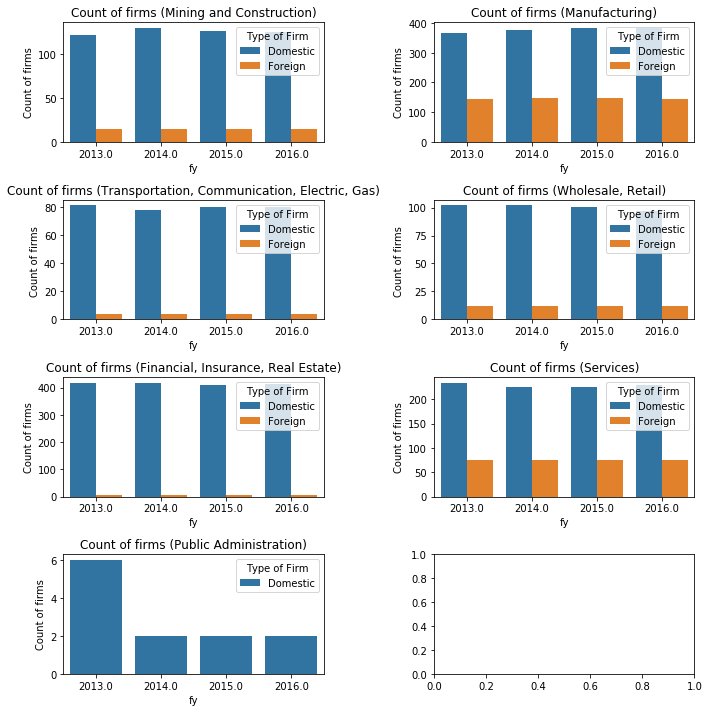

In [106]:
# Count of MNC and domestic firms throughout years for different industries

f, ((ax1, ax2), (ax3, ax4),(ax5,ax6),(ax7,ax8))= plt.subplots(4,2, figsize=(10,10))

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry1_count,ax=ax1)
# ax1.set_yticklabels([0,100,200,300,400,500,600,700])
ax1.set_ylabel('Count of firms')
ax1.set_title('Count of firms (Mining and Construction)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry2_count,ax=ax2)
# ax2.set_yticklabels([0,1,2,3,4,5,6])
ax2.set_ylabel('Count of firms')
ax2.set_title('Count of firms (Manufacturing)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry3_count,ax=ax3)
# ax3.set_yticklabels([0,1,2,3,4,5])
ax3.set_ylabel('Count of firms ')
ax3.set_title('Count of firms (Transportation, Communication, Electric, Gas)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry4_count,ax=ax4)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax4.set_ylabel('Count of firms ')
ax4.set_title('Count of firms (Wholesale, Retail)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry5_count,ax=ax5)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax5.set_ylabel('Count of firms')
ax5.set_title('Count of firms (Financial, Insurance, Real Estate)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry6_count,ax=ax6)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax6.set_ylabel('Count of firms')
ax6.set_title('Count of firms (Services)')

sns.barplot(x='fy',y='Liabilities',hue='Type of Firm',data= liabilities_industry7_count,ax=ax7)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax7.set_ylabel('Count of firms')
ax7.set_title('Count of firms (Public Administration)')

plt.tight_layout()

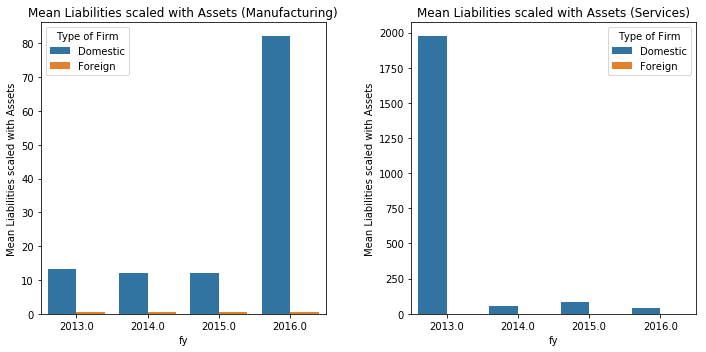

In [107]:
# Mean of (Liabilities / Assets) for MNC and domestic firms throughout years for different industries

f, ((ax1, ax2))= plt.subplots(1,2, figsize=(10,5))

# sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry1_mean_scaled,ax=ax1)
# # ax1.set_yticklabels([0,100,200,300,400,500,600,700])
# ax1.set_ylabel('Mean Liabilities scaled with Assets')
# ax1.set_title('Mean Liabilities scaled with Assets (Mining and Construction)')

sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry2_mean_scaled,ax=ax1)
# ax2.set_yticklabels([0,1,2,3,4,5,6])
ax1.set_ylabel('Mean Liabilities scaled with Assets')
ax1.set_title('Mean Liabilities scaled with Assets (Manufacturing)')

# sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry3_mean_scaled,ax=ax3)
# # ax3.set_yticklabels([0,1,2,3,4,5])
# ax3.set_ylabel('Mean Liabilities scaled with Assets')
# ax3.set_title('Mean Liabilities scaled with Assets (Transportation, Communication, Electric, Gas)')

# sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry4_mean_scaled,ax=ax4)
# # ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax4.set_ylabel('Mean Liabilities scaled with Assets')
# ax4.set_title('Mean Liabilities scaled with Assets (Wholesale, Retail)')

# sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry5_mean_scaled,ax=ax5)
# # ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax5.set_ylabel('Mean Liabilities scaled with Assets')
# ax5.set_title('Mean Liabilities scaled with Assets (Financial, Insurance, Real Estate)')

sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry6_mean_scaled,ax=ax2)
# ax4.set_yticklabels([0,10,20,30,40,50,60,70])
ax2.set_ylabel('Mean Liabilities scaled with Assets')
ax2.set_title('Mean Liabilities scaled with Assets (Services)')

# sns.barplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data= liabilities_industry7_mean_scaled,ax=ax7)
# # ax4.set_yticklabels([0,10,20,30,40,50,60,70])
# ax7.set_ylabel('Mean Liabilities scaled with Assets (by millions)')
# ax7.set_title('Mean Liabilities scaled with Assets (Public Administration)')

plt.tight_layout()

Only Industry 2 (Manufacturing) and Industry 6 (Services) have enough data points to analyze with (100+ observations for both domestic firms and MNCs), so we will be focusing on the manufacturing and Servieces industry and will also plot the undistributed foreign earnings normalized by Assets below to see if the trend supports our hypothesis

In [108]:
liabilities_industry2['UndistributedEarningsOfForeignSubsidiaries_scaled']=\
liabilities_industry2['UndistributedEarningsOfForeignSubsidiaries']/liabilities_industry2['Assets']

In [109]:
liabilities_industry6['UndistributedEarningsOfForeignSubsidiaries_scaled']=\
liabilities_industry6['UndistributedEarningsOfForeignSubsidiaries']/liabilities_industry6['Assets']

Text(0.5,1,'Difference in of Mean normalized Liabilities for Manufacturing Industry (MNCs - Domestic Firms)')

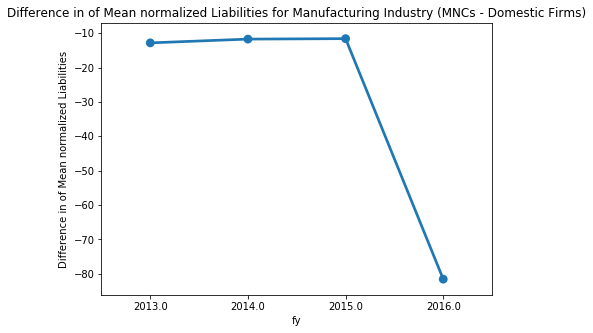

In [110]:
# Manufacturing industry : Mean Liabilities difference (MNCs - Domestic firms)
plt.subplots(figsize=(7,5))
sns.pointplot(x='fy',y='Liabilities_scaled',data= liabilities_industry2_mean_diff)
plt.ylabel('Difference in of Mean normalized Liabilities')
plt.title('Difference in of Mean normalized Liabilities for Manufacturing Industry (MNCs - Domestic Firms)')

Text(0,0.5,'Mean Liabilities normalized')

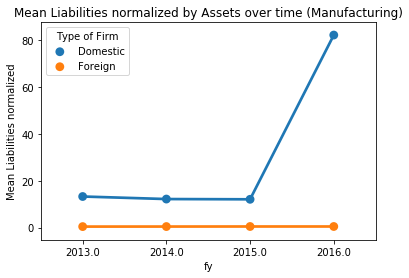

In [111]:
# Manufacturing Industry: Mean Liabilities normalized by Assets over time

sns.pointplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data=liabilities_industry2_mean_scaled)

plt.title('Mean Liabilities normalized by Assets over time (Manufacturing)')
plt.ylabel('Mean Liabilities normalized')

Text(0,0.5,'Mean Liabilities normalized')

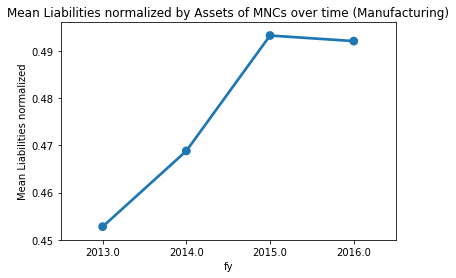

In [112]:
# Manufacturing Industry: Mean Liabilities normalized by Assets of MNCs over time

sns.pointplot(x='fy',y='Liabilities_scaled',
              data=liabilities_industry2_mean_scaled[liabilities_industry2_mean_scaled['Type of Firm']=='Foreign'])

plt.title('Mean Liabilities normalized by Assets of MNCs over time (Manufacturing)')
plt.ylabel('Mean Liabilities normalized')

Text(0.5,1,'Mean Undistributed Foreign Earnings normalized (Manufacturing)')

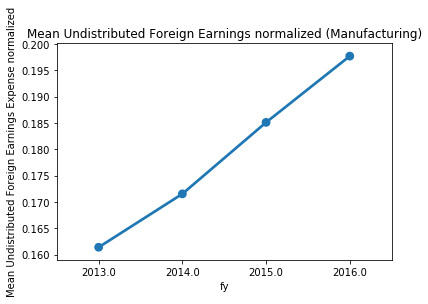

In [114]:
# Mean Normalized Undistributed Foreign Earnings of Manufacturing Industry

sns.pointplot(x='fy',y='UndistributedEarningsOfForeignSubsidiaries_scaled',
              data= pd.DataFrame(liabilities_industry2[liabilities_industry2['Type of Firm']=='Foreign'].\
             groupby(['fy'])['UndistributedEarningsOfForeignSubsidiaries_scaled'].mean()).reset_index())
plt.ylabel('Mean Undistributed Foreign Earnings Expense normalized')
plt.title('Mean Undistributed Foreign Earnings normalized (Manufacturing)')

Text(0.5,1,'Difference in Mean normalized Liabilities for Services Industry')

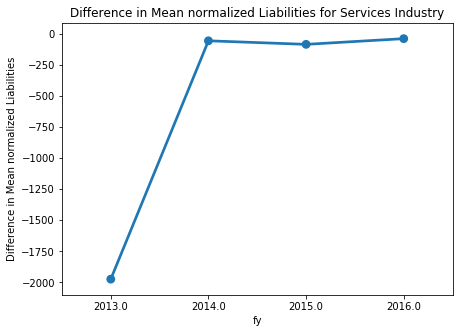

In [115]:
# Services industry : Mean Liabilities difference (MNCs - Domestic)
plt.subplots(figsize=(7,5))
sns.pointplot(x='fy',y='Liabilities_scaled',data= liabilities_industry6_mean_diff)
plt.ylabel('Difference in Mean normalized Liabilities')
plt.title('Difference in Mean normalized Liabilities for Services Industry')

Text(0,0.5,'Mean Liabilities normalized')

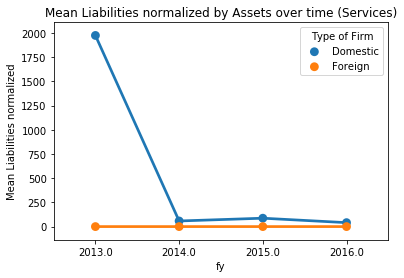

In [116]:
# Services Industry: Mean Normalized Liabilities over time

sns.pointplot(x='fy',y='Liabilities_scaled',hue='Type of Firm',data=liabilities_industry6_mean_scaled)

plt.title('Mean Liabilities normalized by Assets over time (Services)')
plt.ylabel('Mean Liabilities normalized')